In [2]:
import gdal
import os
import numpy as np
import matplotlib.pyplot as plt

# For colorbalancing
import cv2
import math

In [3]:
!ls /datasets/Shanghai/AOI_4_Shanghai_Train/

geojson  MUL  MUL-PanSharpen  PAN  RGB-PanSharpen  summaryData


In [4]:
basedir = '/datasets/Shanghai/AOI_4_Shanghai_Train/RGB-PanSharpen/'
fnames = [fname for fname in os.listdir(basedir) if fname[-3:] == 'tif']

In [112]:
def load_tiff(fname):
    tiff = gdal.Open(fname, gdal.GA_ReadOnly)
    arr = [tiff.GetRasterBand(idx).ReadAsArray() for idx in range(1, tiff.RasterCount+1)]
    return np.dstack(arr)

def invesigate_dir(basedir, fnames):
    MAXS = [0, 0, 0]
    MINS = [10000, 10000, 10000]
    for fn in fnames:
        arr = load_tiff(basedir+fn)
        maxs = [arr[...,i].max() for i in range(3)]
        mins = [arr[...,i].min() for i in range(3)]
        for i in range(len(MAXS)):
            if maxs[i] > MAXS[i]:
                MAXS[i] = maxs[i]
            if mins[i] < MINS[i]:
                MINS[i] = mins[i]
    return MAXS, MINS

RGB Ranges:

Shanghai: (1595, 1769, 1535)

Vegas: (1744, 2047, 1610)

It seems all data is really in range \[0, 2047\]. So that's what we'll use when we visualize our data. Actually, putting the data in this range just looks more green, so we'll colorbalance the images.

In [123]:
def standardize(x):
    return x / (2047)

def apply_mask(matrix, mask, fill_value):
    masked = np.ma.array(matrix, mask=mask, fill_value=fill_value)
    return masked.filled()

def apply_threshold(matrix, low_value, high_value):
    low_mask = matrix < low_value
    matrix = apply_mask(matrix, low_mask, low_value)

    high_mask = matrix > high_value
    matrix = apply_mask(matrix, high_mask, high_value)

    return matrix

def simplest_cb(img, percent=1):
    """Colorbalances images
    taken from: https://gist.github.com/DavidYKay/9dad6c4ab0d8d7dbf3dc"""
    assert img.shape[2] == 3
    assert percent > 0 and percent < 100

    half_percent = percent / 200.0

    channels = cv2.split(img)

    out_channels = []
    for channel in channels:
        assert len(channel.shape) == 2
        # find the low and high precentile values (based on the input percentile)
        height, width = channel.shape
        vec_size = width * height
        flat = channel.reshape(vec_size)

        assert len(flat.shape) == 1

        flat = np.sort(flat)

        n_cols = flat.shape[0]

        low_val  = flat[int(math.floor(n_cols * half_percent))]
        high_val = flat[int(math.ceil( n_cols * (1.0 - half_percent)))]
        # saturate below the low percentile and above the high percentile
        thresholded = apply_threshold(channel, low_val, high_val)
        # scale the channel
        normalized = cv2.normalize(thresholded, thresholded.copy(), 0, 255, cv2.NORM_MINMAX)
        out_channels.append(normalized)

    return cv2.merge(out_channels)

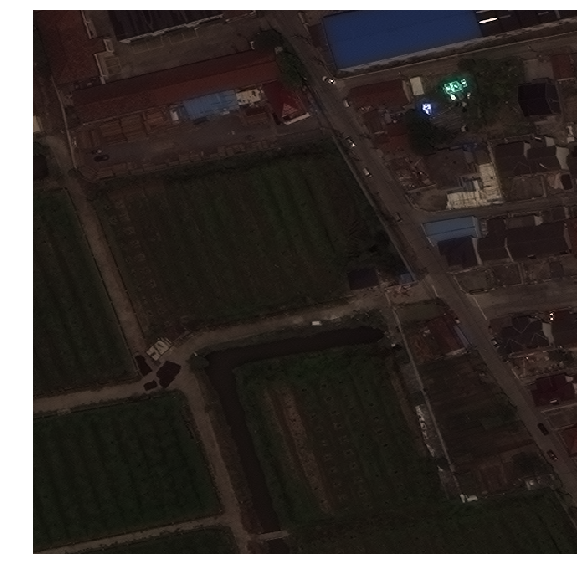

In [180]:
arr = load_tiff(basedir+np.random.choice(os.listdir(basedir)))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.imshow(simplest_cb(arr, 0.01))